# 2. Data Preparation
This notebook prepares the dataset for building supervised learning models to classify mushrooms as **poisonous** or **edible**.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [133]:
# Load dataset
df = pd.read_csv('./Data/train.csv')
print("Train dataset shape:", df.shape)

Train dataset shape: (3116945, 22)


## 0. Sampling Strategy

To improve efficiency and maintain reproducibility, a random sample of 100,000 rows was taken from the full dataset (~3.1M rows). Sampling preserves the original class distribution using a fixed random seed (42).


In [134]:
df = df.sample(n=100_000, random_state=42).reset_index(drop=True)
print("Sampled dataset shape:", df.shape)
df.head()

Sampled dataset shape: (100000, 22)


,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,1356763,p,7.82,s,t,r,t,d,NaN,g,...,NaN,t,g,NaN,NaN,f,f,NaN,d,a
1,2369311,p,3.20,o,NaN,g,f,f,f,f,...,NaN,g,n,NaN,NaN,f,f,NaN,d,s
2,1146527,e,9.36,f,NaN,n,t,NaN,NaN,w,...,b,NaN,w,NaN,w,t,g,NaN,d,a
3,889383,p,6.52,s,d,e,t,d,c,w,...,NaN,NaN,e,NaN,NaN,f,f,NaN,d,a
4,416134,p,3.13,b,t,n,f,NaN,NaN,n,...,NaN,NaN,w,NaN,NaN,t,NaN,k,g,u


## 1. Adressing data quality

In this section, we assess the completeness, uniqueness, and accuracy of the dataset, and apply necessary modifications to ensure high-quality data for model training.

### Completeness
As identified in the Data Understanding phase, several features in the dataset contain missing values. It's essential to handle these appropriately before moving forward.

We first inspect:
- Which columns contain missing values
- Whether any columns have no values at all
- Whether any columns contain only a single unique value

In [135]:
# Check for missing values
print("Columns with missing values:\n", df.loc[:, df.isnull().any()].columns)
# Chekc for null columns
print("Columns with no values:\n", df.loc[:, df.isnull().all()].columns)
# Check for uniques by column
print("Columns with only one value:\n", df.loc[:, df.nunique() == 1].columns)

Columns with missing values:
 Index(['cap-shape', 'cap-surface', 'gill-attachment', 'gill-spacing',
       'gill-color', 'stem-root', 'stem-surface', 'veil-type', 'veil-color',
       'has-ring', 'ring-type', 'spore-print-color', 'habitat'],
      dtype='object')
Columns with no values:
 Index([], dtype='object')
Columns with only one value:
 Index([], dtype='object')


A significant number of columns contain missing values.

#### Handling Missing Values

For now, we replace all missing entries with the placeholder "unknown". This preserves the rows and treats unknowns as valid categories, which is suitable for tree-based models.

In [136]:
df.fillna('unknown', inplace=True)

# Check for missing values
print("Columns with missing values:\n", df.loc[:, df.isnull().any()].columns)


Columns with missing values:
 Index([], dtype='object')


We confirm that all missing values have been addressed:

### Uniqueness
To ensure data integrity, we verify that each record in the dataset is unique. This check helps detect and prevent duplicate entries that could bias the model.

In [137]:
#check for duplicates
print(df.duplicated().sum())

0


### Accuracy
To assess data accuracy, we verify whether any values in the numerical columns fall outside of expected ranges. For this dataset, numerical values (e.g., sizes and dimensions) are expected to be non-negative.

In [138]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])
# check if any numerical columns have negative values
print(numeric_columns.loc[:, numeric_columns.lt(0).any()])

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[100000 rows x 0 columns]


All numerical values are valid and non-negative. No unexpected entries were detected.

## 2. Data Cleaning

### Redundancy
The column id does not contribute any meaningful information for the modeling process. Since it serves only as a row identifier and holds no predictive value, we remove it from the dataset:

In [139]:
df = df.drop(columns='id')

### Outliers
#### Categorical Features
From the Data Understanding phase, we identified a number of rare categories in some categorical variables. These infrequent values may stem from data entry inconsistencies or may introduce unnecessary noise during training.

To mitigate this, we apply a rare-category encoding strategy. Any category that occurs in less than 1% of the dataset is replaced with a generic label 'Rare'.

In [140]:
categorical_features = df.select_dtypes(include='object').drop(columns='class').columns.tolist()

threshold = 0.01

for col in categorical_features:
    frequency = df[col].value_counts(normalize=True)
    rare_labels = frequency[frequency < threshold].index
    df[col] = df[col].replace(rare_labels, 'Rare')

#### Numerical Features
Several numerical columns exhibited extreme skew and outliers, which can negatively affect distance-based or linear models. To address this, we apply a logarithmic transformation to compress large values and reduce skewness:

In [141]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in numeric_features:
    df[col] = np.log1p(df[col])

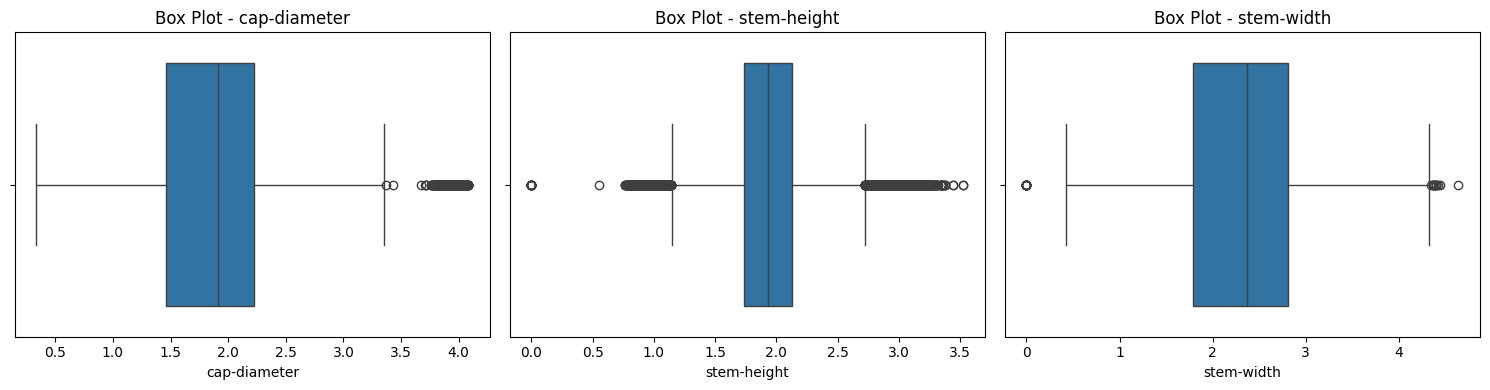

In [142]:
num_features = len(numeric_features)
cols = 3
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.boxplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Box Plot - {feature}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

After the transformation, the updated box plots show a significantly more symmetric and compact distribution across all numeric features. The number and intensity of outliers have visibly decreased, improving the robustness and fairness of the upcoming model training phase.

However, `stem-height` and `stem-width` still contain the value `0`, which should be impossible as these are dimensions.
To address this issue we will replace these values with their respective medians.

In [143]:
df['stem-height'] = df['stem-height'].replace(0, np.nan)
df['stem-width'] = df['stem-width'].replace(0, np.nan)

df['stem-height'] = df['stem-height'].fillna(df['stem-height'].median())
df['stem-width'] = df['stem-width'].fillna(df['stem-width'].median())

These transformations effectively reduce skew. We choose not to remove any additional data points to preserve the integrity of potentially valuable, though extreme, examples. This decision favors model generalization over aggressive outlier removal.

## 3. Feature Engineering

Feature engineering is a critical step in the machine learning pipeline, as it enables models to capture complex patterns and improve predictive performance. In this section, we derive new features from the existing dataset to better represent domain-specific relationships, reduce noise, and enhance model interpretability.

The techniques applied here include:
- **Interaction features** to reflect geometric relationships.
- **Combined categorical features** to capture structural or environmental interactions.
- **Simplification of categories** to reduce cardinality and highlight meaningful groupings.
- **Binning of numeric values** to discretize continuous data and expose ordinal relationships.

These engineered features aim to enrich the dataset with more informative and expressive representations of the original attributes, thereby supporting more accurate and robust classification models.


#### Iteraction Features
These features are derived from arithmetic combinations of numeric variables (e.g., height × width), aiming to represent physical characteristics like area, volume, or proportional ratios.

In [144]:
df['stem-area'] = df['stem-height'] * df['stem-width']
df['stem-volume'] = df['stem-area'] * df['stem-width']
df['stem-ratio'] = df['stem-height'] / (df['stem-width'])
df['cap-stem-ratio'] = df['cap-diameter'] / (df['stem-height'] + df['stem-width'])

#### Attaching Features
New features created by combining pairs of categorical values that are likely to have interactive effects — e.g., the relationship between gill spacing and attachment.

In [145]:
df['gill-type'] = df['gill-attachment'] + "_" + df['gill-spacing']
df['ring-profile'] = df['has-ring'] + "_" + df['ring-type']
df['habitat-season'] = df['habitat'] + "_" + df['season']
df['cap-surface-shape'] = df['cap-surface'] + "_" + df['cap-shape']
df['stem-root-surface'] = df['stem-root'] + "_" + df['stem-surface']

#### Simplifying Features
Transformations that reduce the cardinality of categorical features by grouping similar values together (e.g., dark/light colors, warm/cold seasons), improving model interpretability and reducing noise.

Unfortunately, due to the lack of documentation regarding the meaning of each column's values, this type of feature engineering could not be explored as extensively as desired.

In [146]:
df['has-root'] = df['stem-root'].apply(lambda x: 'yes' if x not in ['unknown'] else 'no')

warm_seasons = ['u', 's']
cold_seasons = ['a', 'w']

df['season-type'] = df['season'].apply(lambda x: 'warm' if x in warm_seasons else 'cold')

#### Binning
Continuous numeric values are discretized into categorical bins (e.g., small/medium/large). This is especially useful for tree-based models or when interpretability is preferred.

In [147]:
df['cap-diameter-bin'] = pd.qcut(df['cap-diameter'], q=3, labels=['small', 'medium', 'large'])
df['stem-height-bin'] = pd.qcut(df['stem-height'], q=3, labels=['short', 'medium', 'tall'])
df['stem-width-bin'] = pd.qcut(df['stem-width'], q=3, labels=['narrow', 'medium', 'wide'])
df['stem-volume-bin'] = pd.qcut(df['stem-volume'], q=3, labels=['small', 'medium', 'large'])
df['stem-area-bin'] = pd.qcut(df['stem-area'], q=3, labels=['small', 'medium', 'large'])
df['stem-ratio-bin'] = pd.qcut(df['stem-ratio'], q=3, labels=['low', 'medium', 'high'])
df['cap-stem-ratio-bin'] = pd.qcut(df['cap-stem-ratio'], q=3, labels=['low', 'medium', 'high'])

## 4. Saving the Data

In [148]:
df.to_csv('./Data/processed_train.csv', index=False)

## Full Dataset

In [31]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [32]:
# Load dataset
df = pd.read_csv('./Data/train.csv')

In [33]:
df.fillna('unknown', inplace=True)

/tmp/ipykernel_7253/3438581698.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('unknown', inplace=True)


In [34]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

In [35]:
df = df.drop(columns='id')

In [36]:
df['cap-diameter'] = pd.to_numeric(df['cap-diameter'], errors='coerce').fillna(0)

In [37]:
categorical_features = df.select_dtypes(include='object').drop(columns='class').columns.tolist()

threshold = 0.01

for col in categorical_features:
    frequency = df[col].value_counts(normalize=True)
    rare_labels = frequency[frequency < threshold].index
    df[col] = df[col].replace(rare_labels, 'Rare')

In [38]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in numeric_features:
    df[col] = np.log1p(df[col])


In [39]:
print(df['cap-diameter'].unique())

[2.28238239 1.70656462 2.07191328 ... 3.66637819 4.03653888 4.0086051 ]


In [40]:
df['stem-height'] = df['stem-height'].replace(0, np.nan)
df['stem-width'] = df['stem-width'].replace(0, np.nan)

df['stem-height'] = df['stem-height'].fillna(df['stem-height'].median())
df['stem-width'] = df['stem-width'].fillna(df['stem-width'].median())

In [41]:
df['stem-area'] = df['stem-height'] * df['stem-width']
df['stem-volume'] = df['stem-area'] * df['stem-width']
df['stem-ratio'] = df['stem-height'] / (df['stem-width'])
df['cap-stem-ratio'] = df['cap-diameter'] / (df['stem-height'] + df['stem-width'])

In [42]:
df['gill-type'] = df['gill-attachment'] + "_" + df['gill-spacing']
df['ring-profile'] = df['has-ring'] + "_" + df['ring-type']
df['habitat-season'] = df['habitat'] + "_" + df['season']
df['cap-surface-shape'] = df['cap-surface'] + "_" + df['cap-shape']
df['stem-root-surface'] = df['stem-root'] + "_" + df['stem-surface']

In [43]:
df['has-root'] = df['stem-root'].apply(lambda x: 'yes' if x not in ['unknown'] else 'no')

warm_seasons = ['u', 's']
cold_seasons = ['a', 'w']

df['season-type'] = df['season'].apply(lambda x: 'warm' if x in warm_seasons else 'cold')

In [44]:
if df['cap-diameter'].nunique() > 1:
    df['cap-diameter-bin'] = pd.qcut(df['cap-diameter'], q=3, labels=['small', 'medium', 'large'])
else:
    print("cap-diameter has only one unique value — skipping binning.")


In [45]:
df['cap-diameter-bin'] = pd.qcut(df['cap-diameter'], q=3, labels=['small', 'medium', 'large'])
df['stem-height-bin'] = pd.qcut(df['stem-height'], q=3, labels=['short', 'medium', 'tall'])
df['stem-width-bin'] = pd.qcut(df['stem-width'], q=3, labels=['narrow', 'medium', 'wide'])
df['stem-volume-bin'] = pd.qcut(df['stem-volume'], q=3, labels=['small', 'medium', 'large'])
df['stem-area-bin'] = pd.qcut(df['stem-area'], q=3, labels=['small', 'medium', 'large'])
df['stem-ratio-bin'] = pd.qcut(df['stem-ratio'], q=3, labels=['low', 'medium', 'high'])
df['cap-stem-ratio-bin'] = pd.qcut(df['cap-stem-ratio'], q=3, labels=['low', 'medium', 'high'])

In [46]:
df.to_csv('./Data/processed_train_full.csv', index=False)